本模块主要用于初步熟悉pytorch，以mnist数据作为例子，了解pytorch神经网络的构建。<br>
参考https://github.com/fastai/fastai_docs/tree/master/dev_nb

### pathlib使用

In [1]:
from pathlib import Path

# 打印路径下所有文件
print([x for x in Path('.').iterdir() if x.is_file()])

# 遍历查找python文件
print(list(Path('.').glob('**/*.py')))

# 查看文件是否存在
print((Path('.')/'data_util.py').exists())

# 创建文件夹
path = Path('data')/'mnist'
path.mkdir(parents=True, exist_ok=True)

[PosixPath('data_util.py'), PosixPath('README.md'), PosixPath('.gitignore'), PosixPath('logistic_regression.py'), PosixPath('newer.ipynb')]
[PosixPath('data_util.py'), PosixPath('logistic_regression.py')]
True


### 下载数据

In [2]:
import requests
# requests.get(url, params=None, **kwargs)
# requests.post(url, data=None, json=None, **kwargs)

url='http://deeplearning.net/data/mnist/'
filename='mnist.pkl.gz'

if not (path/filename).exists():
    content = requests.get(url+filename).content
    (path/filename).open('wb').write(content)

### 读取数据

In [3]:
import pickle, gzip
with gzip.open(path/filename, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

### 数据预览

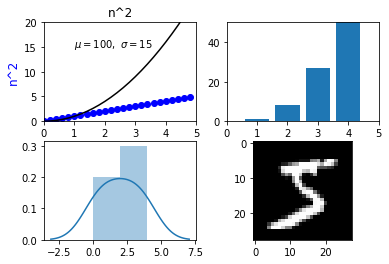

In [30]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sn

# 参考https://matplotlib.org/api/pyplot_api.html
# 参考http://seaborn.pydata.org/api.html

plt.figure(1)
# 子图1
plt.subplot(221)
t=np.arange(0,5,0.2)
plt.plot(t, t, 'bo', t, t**2, 'k')
plt.xlabel('n',fontsize=14,color='red')
plt.ylabel('n^2',fontsize=12,color='blue')
plt.title('n^2')
plt.text(1, 15, r'$\mu=100,\ \sigma=15$')
plt.axis([0,5,0,20])
# 子图2
plt.subplot(222)
t=np.arange(0,5,1)
plt.bar(t, t**3)
plt.axis([0,5,0,50])
# 子图3
plt.subplot(223)
sn.distplot(t)
# 子图4
plt.subplot(224)
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")

### 转换成tensor
pytorch使用torch.tensor

In [25]:
import torch

x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([50000, 784]),
 tensor(0),
 tensor(9))

### 网络简单实现

In [31]:
import math

weights = torch.randn(784,10)/math.sqrt(784) #  Xavier initialisation (by multiplying with 1/sqrt(n)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

def log_softmax(x):
    # softmax
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def inference(xb):
    # 模型
    return log_softmax(xb @ weights + bias) # @表示点积

def loss_func(logits, labels): 
    # negative log-likelihood损失函数
    return -logits[range(labels.shape[0]), labels].mean()

def accuracy(logits, labels):
    # 准确率
    preds = torch.argmax(logits, dim=1)
    return (preds==labels).float().mean()

lr = 0.1
epochs = 2
batch_size = 64
for epoch in range(epochs):
    for i in range((n-1)//batch_size + 1):
        start_i = i*batch_size
        end_i = start_i+batch_size
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = inference(xb)
        loss = loss_func(pred, yb)
        if epoch==0 and i==0:
            print(pred[0])
            print(pred.shape)
            print(loss)
        
        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

loss_func(inference(x_valid), y_valid), accuracy(inference(x_valid), y_valid)

tensor([-2.0049, -2.3384, -2.9095, -2.3667, -2.8304, -3.0138, -1.9534, -2.1692,
        -2.2988, -1.8579], grad_fn=<SelectBackward>)
torch.Size([64, 10])
tensor(2.2247, grad_fn=<NegBackward>)
tensor([ -4.3791,  -8.1846,  -5.3384,  -0.9522, -10.0164,  -0.5696,  -6.0120,
         -4.1006,  -4.6914,  -5.9999], grad_fn=<SelectBackward>)
torch.Size([64, 10])
tensor(0.3474, grad_fn=<NegBackward>)


(tensor(0.3091, grad_fn=<NegBackward>), tensor(0.9143))

### 用torch实现网络

In [63]:
from torch.nn.functional import cross_entropy # 损失函数
from torch import nn # 网络结构
from torch import optim # 优化函数
from torch.utils.data import TensorDataset # 数据模块
from torch.utils.data import DataLoader # 数据载入模块

class Mnist_Logistic(nn.Module):
    # 模型部分，自动调用forward
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb): 
        return self.lin(xb)


def loss_batch(model, loss_func, xb, yb, opt=None):
    # 优化部分，计算损失并进行优化
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)


def get_data(train_ds, valid_ds, bs):
    # 数据分批获取
    return (DataLoader(train_ds, batch_size=bs, shuffle=True), DataLoader(valid_ds, batch_size=bs*2))
    

def get_model():
    # 获取模型，损失函数和优化器
    model = Mnist_Logistic()
    return model, cross_entropy, optim.SGD(model.parameters(), lr=lr)


def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    # 训练并评估
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl: 
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(*[loss_batch(model, loss_func, xb, yb) for xb,yb in valid_dl])
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        print(epoch, val_loss)


# 参数
lr = 0.1
epochs = 2
batch_size = 64

# 主函数
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
train_dl, valid_dl = get_data(train_ds, valid_ds, batch_size)
model, loss_func, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.339472701883316
1 0.3085630487680435


### 转化为cnn模型

In [64]:
from torch.nn.functional import relu, avg_pool2d

class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,  16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1,1,28,28)
        xb = relu(self.conv1(xb))
        xb = relu(self.conv2(xb))
        xb = relu(self.conv3(xb))
        xb = avg_pool2d(xb, 4)
        return xb.view(xb.size(0), -1)


def get_model():
    model = Mnist_CNN()
    opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    return model, cross_entropy, opt

model, loss_func, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3478482967376709
1 0.22727216510772705


### 使用Sequential创建模型

In [65]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func=func
    
    def forward(self, x):
        return self.func(x)


def get_model():
    model = nn.Sequential(
        Lambda(lambda x: x.view(-1,1,28,28)),
        nn.Conv2d(1,  16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1), nn.ReLU(),
        nn.AdaptiveAvgPool2d(1),
        Lambda(lambda x: x.view(x.size(0), -1))
    )
    opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    return model, cross_entropy, opt


model, loss_func, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.33131165542602536
1 0.2518024257183075


### 模型拓展，使用gpu

typing模块：<br>
常用类型 <br>
int,long,float: 整型,长整形,浮点型; <br>
bool,str: 布尔型，字符串类型；<br>
List, Tuple, Dict, Set:列表，元组，字典, 集合; <br>
Iterable,Iterator:可迭代类型，迭代器类型；<br>
Generator：生成器类型 <br>
特点 <br>
在传入参数时通过“参数名:类型”的形式声明参数的类型； <br>
返回结果通过"-> 结果类型"的形式声明结果的类型。 <br>
在调用的时候如果参数的类型不正确pycharm会有提醒，但不会影响程序的运行。 <br>
对于如list列表等，还可以规定得更加具体一些，如：“-> List[str]”,规定返回的是列表，并且元素是字符串。 <br>
由于python天生支持多态，迭代器中的元素可能多种，“-> List[int or str]” <br>

In [1]:
import pickle, gzip, torch, math, numpy as np, torch.nn.functional as F
from pathlib import Path
from IPython.core.debugger import set_trace
from typing import Any, Collection, Callable, NewType, List, Union, TypeVar, Optional
from functools import partial, reduce
from numbers import Number

from numpy import array
from torch import nn, optim, tensor, Tensor
from torch.utils.data import TensorDataset, Dataset, DataLoader

In [2]:
def mnist2image(b): 
    # 定义数据转换操作，对数据进行resize
    return b.view(1,28,28)

class DatasetTfm(Dataset):
    # 对数据进行转换
    def __init__(self, ds:Dataset, tfm:Callable=None):
        self.ds = ds
        self.tfm = tfm
        
    def __len__(self): 
        return len(self.ds)
    
    def __getitem__(self,idx:int):
        # 对数据进行转换并返回第idx个元素
        x,y = self.ds[idx]
        if self.tfm is not None: 
            x = self.tfm(x)
        return x,y

In [3]:
def ifnone(a:bool, b:Any):
    return b if a is None else a

def is_listy(x:Any)->bool: 
    return isinstance(x, (tuple,list))

default_device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
Tensors = Union[Tensor, Collection['Tensors']]

def to_device(b:Tensors, device:torch.device):
    # 将tensors转换到gpu上
    device = ifnone(device, default_device)
    if is_listy(b): 
        return [to_device(o, device) for o in b]
    return b.to(device)

class DeviceDataLoader():
    # 载入数据并保证数据在gpu上
    def __init__(self, dl:DataLoader, device: torch.device):
        self.dl = dl
        self.device = device

    def __len__(self) -> int: 
        return len(self.dl)
    
    def proc_batch(self,b:Tensors): 
        return to_device(b, self.device)

    def __iter__(self)->Tensors:
        self.gen = map(self.proc_batch, self.dl)
        return iter(self.gen)

    @classmethod
    def create(cls, *args, device:torch.device=default_device, **kwargs): 
        return cls(DataLoader(*args, **kwargs), device=device)

In [4]:
TItem = TypeVar('TItem')
TfmCallable = Callable[[TItem],TItem]
TfmList = Union[TfmCallable, Collection[TfmCallable]]
Tfms = Optional[TfmList]

class DataBunch():
    def __init__(self, train_dl: DataLoader, valid_dl: DataLoader, device: torch.device=None):
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.device = device

    @classmethod
    def create(cls, train_ds:Dataset, valid_ds:Dataset, batch_size:int=64, 
               train_tfm:Tfms=None, valid_tfm:Tfms=None, device:torch.device=None, **kwargs):
        return cls(DeviceDataLoader.create(DatasetTfm(train_ds, train_tfm), batch_size, shuffle=True, device=device, **kwargs),
                   DeviceDataLoader.create(DatasetTfm(valid_ds, valid_tfm), batch_size*2, shuffle=False, device=device, **kwargs),
                   device=device)

In [5]:
LambdaFunc = Callable[[Tensor],Tensor]
class Lambda(nn.Module):
    "An easy way to create a pytorch layer for a simple `func`"
    def __init__(self, func:LambdaFunc):
        "create a layer that simply calls `func` with `x`"
        super().__init__()
        self.func=func
        
    def forward(self, x): return self.func(x)


def noop(x): return x

def ResizeBatch(*size:int) -> Tensor: 
    # 修改输入大小到指定维度
    return Lambda(lambda x: x.view((-1,)+size))

def Flatten()->Tensor: 
    # 将输入变为1维
    return Lambda(lambda x: x.view((x.size(0), -1)))

def PoolFlatten()->nn.Sequential:
    # 先池化再平滑
    return nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten())

def conv2d(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bias=False) -> nn.Conv2d:
    # 卷积层
    if padding is None: 
        padding = ks//2
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=padding, bias=bias)

def conv2d_relu(ni:int, nf:int, ks:int=3, stride:int=1, padding:int=None, bn:bool=False) -> nn.Sequential:
    # 卷积层+relu+batchnormalization
    layers = [conv2d(ni, nf, ks=ks, stride=stride, padding=padding), nn.ReLU()]
    if bn: 
        layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

def conv2d_trans(ni:int, nf:int, ks:int=2, stride:int=2, padding:int=0) -> nn.ConvTranspose2d:
    # 反卷积层
    return nn.ConvTranspose2d(ni, nf, kernel_size=ks, stride=stride, padding=padding)

def simple_cnn(actns:Collection[int], kernel_szs:Collection[int], strides:Collection[int]) -> nn.Sequential:
    # 构造cnn
    layers = [conv2d_relu(actns[i], actns[i+1], kernel_szs[i], stride=strides[i]) for i in range(len(strides))]
    layers.append(PoolFlatten())
    return nn.Sequential(*layers)

In [6]:
Rank0Tensor = NewType('OneEltTensor', Tensor)
LossFunction = Callable[[Tensor, Tensor], Rank0Tensor]
Model = nn.Module

def loss_batch(model:Model, xb:Tensor, yb:Tensor, loss_fn:LossFunction, opt:optim.Optimizer=None):
    # 计算批次损失函数
    if not is_listy(xb): xb = [xb]
    if not is_listy(yb): yb = [yb]
    loss = loss_fn(model(*xb), *yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    return loss.item(), len(yb)

def fit(epochs:int, model:Model, loss_fn:LossFunction, opt:optim.Optimizer, train_dl:DataLoader, valid_dl:DataLoader):
    "Train `model` on `train_dl` with `optim` then validate against `valid_dl`"
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl: loss,_ = loss_batch(model, xb, yb, loss_fn, opt)

        model.eval()
        with torch.no_grad():
            losses,nums = zip(*[loss_batch(model, xb, yb, loss_fn) for xb,yb in valid_dl])
        val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)

        print(epoch, val_loss)

class Learner():
    # 训练模型
    def __init__(self, data:DataBunch, model:Model):
        self.data,self.model = data,to_device(model, data.device)

    def fit(self, epochs, lr, loss_fn=F.cross_entropy, opt_fn=optim.SGD):
        opt = opt_fn(self.model.parameters(), lr=lr)
        fit(epochs, self.model, loss_fn, opt, self.data.train_dl, self.data.valid_dl)

In [7]:
path = Path('data')/'mnist'
filename='mnist.pkl.gz'
lr = 0.1
with gzip.open(path/filename, 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)

data = DataBunch.create(train_ds, valid_ds, batch_size=64, train_tfm=mnist2image, valid_tfm=mnist2image)
model = simple_cnn([1,16,16,10], [3,3,3], [2,2,2])
learner = Learner(data, model)
opt_fn = partial(optim.SGD, momentum=0.9) # 固定部分参数
learner.fit(2, lr, opt_fn=opt_fn)

0 0.37553350797182394
1 0.26548658396247066
